# LeNet

ps：

pip install d2l

pip install matplotlib==3.0.0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

1. 定义网络

In [3]:
class Reshape(torch.nn.Module):

  def forward(self, x):
    return x.reshape(-1, 1, 28, 28)

In [4]:
net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

In [5]:
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output: \t', X.shape)

Reshape output: 	 torch.Size([1, 1, 28, 28])
Conv2d output: 	 torch.Size([1, 6, 28, 28])
Sigmoid output: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output: 	 torch.Size([1, 6, 14, 14])
Conv2d output: 	 torch.Size([1, 16, 10, 10])
Sigmoid output: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output: 	 torch.Size([1, 16, 5, 5])
Flatten output: 	 torch.Size([1, 400])
Linear output: 	 torch.Size([1, 120])
Sigmoid output: 	 torch.Size([1, 120])
Linear output: 	 torch.Size([1, 84])
Sigmoid output: 	 torch.Size([1, 84])
Linear output: 	 torch.Size([1, 10])


2. 载入数据集

In [6]:
batch_size = 256
train_data, test_data = d2l.load_data_fashion_mnist(batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3. 初始化权重

In [7]:
def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Reshape()
  (1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): Sigmoid()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Sigmoid()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=400, out_features=120, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=84, out_features=10, bias=True)
)

4. 定义loss

In [8]:
l = nn.CrossEntropyLoss()

5. 定义优化器

In [9]:
o = torch.optim.SGD(net.parameters(), lr=0.5)

6. Training and Prediction

In [10]:
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

def eval_accu(net=None, dataset=None, cuda=False):
  
  accu = 0
  batch = 0
  net.eval()

  for X,y in dataset:
    if cuda:
      net.cuda()
      X,y = X.cuda(),y.cuda()
    accu += acc(X, y, net)
    batch += 1
  avg_acc = accu/batch

  return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
  train_accu_history = []
  test_accu_history = []
  train_loss = []

  for epoch in range(epochs):

    net.train()
    for X,y in train_iter:
      if cuda:
        net.cuda()
        X,y = X.cuda(),y.cuda()
      l = loss(net(X), y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    net.eval() 
    l = loss(net(X), y)
    train_loss.append(l.cpu().detach())
    

    train_avg_acc = eval_accu(net, train_iter, cuda)
    test_avg_acc = eval_accu(net, test_iter, cuda)
    train_accu_history.append(train_avg_acc)
    test_accu_history.append(test_avg_acc)

    print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {test_avg_acc:f}')
  
  x_label_value = [str(i) for i in range(1,epochs+1)]
  plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
  plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
  plt.plot(x_label_value, train_loss, label='train_loss', color='b')
  plt.xlabel('epoch')
  plt.ylim(0.1,2)
  plt.legend()
  plt.show()

- CPU训练

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 2.260965, train_accu 0.100066, test_accu 0.099121
epoch 2, loss 1.130547, train_accu 0.535151, test_accu 0.538184
epoch 3, loss 1.268609, train_accu 0.515869, test_accu 0.514062
epoch 4, loss 0.658577, train_accu 0.707868, test_accu 0.701172
epoch 5, loss 0.757813, train_accu 0.733439, test_accu 0.730859
epoch 6, loss 0.717919, train_accu 0.751130, test_accu 0.749316
epoch 7, loss 0.654537, train_accu 0.745279, test_accu 0.738574
epoch 8, loss 0.408740, train_accu 0.754704, test_accu 0.748535
epoch 9, loss 0.621925, train_accu 0.781267, test_accu 0.773438
epoch 10, loss 0.537485, train_accu 0.758156, test_accu 0.752441


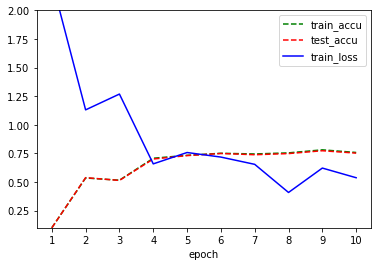

CPU times: user 3min 19s, sys: 7.16 s, total: 3min 26s
Wall time: 3min 53s


In [11]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_data, test_iter=test_data, cuda=False)

- GPU训练

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.474776, train_accu 0.802721, test_accu 0.796680
epoch 2, loss 0.346297, train_accu 0.781965, test_accu 0.773926
epoch 3, loss 0.389307, train_accu 0.816888, test_accu 0.807617
epoch 4, loss 0.442656, train_accu 0.790531, test_accu 0.785156
epoch 5, loss 0.415944, train_accu 0.819398, test_accu 0.807227
epoch 6, loss 0.310927, train_accu 0.787489, test_accu 0.770117
epoch 7, loss 0.399142, train_accu 0.835516, test_accu 0.826367
epoch 8, loss 0.291702, train_accu 0.839766, test_accu 0.827148
epoch 9, loss 0.304158, train_accu 0.822579, test_accu 0.816406
epoch 10, loss 0.343432, train_accu 0.811480, test_accu 0.805664


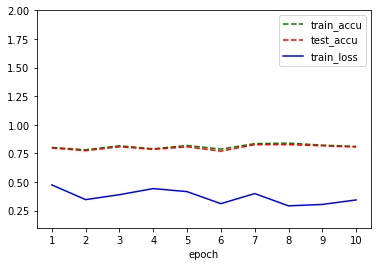

CPU times: user 22.4 s, sys: 7.73 s, total: 30.1 s
Wall time: 2min


In [12]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_data, test_iter=test_data, cuda=True)